# PROYECTO INTEGRADOR

# ANÁLISIS DE SENTIMIENTOS EN RESEÑAS DE PROFESORES

# NOTEBOOK 3: MODELO DEEP LEARNING

Se utilizará un modelo **Distilbert**.

## Cargar los datos

In [ ]:
import pandas as pd

In [28]:
df = pd.read_csv('/content/sample_data/dataset.csv')
df.head()

,StudentComments,Sentiment
0,good,1
1,teacher,1
2,friendly teacher but not enough ability to enc...,1
3,he is a good techer.,1
4,he is agood techer.,1


## Importación de librerías y Tokenización

Se importan las distintas librerías necesarias para realizar el proyecto y se carga un tokenizer preentrenado: **distilbert-base-uncased**.

Se define una función para tokenizar por lotes (batches) los comentarios de los estudiantes, cortando (truncation) y rellenando (padding) los textos a una longitud fija de **128 tokens**.

Se calculan pesos balanceados para cada clase en función de su frecuencia en los datos, dando mayor peso a las clases menos representadas (reseñas negativas). Estos pesos se convierten en un **tensor de PyTorch** para usarlos durante el entrenamiento y así evitar que el modelo favorezca la clase mayoritaria.

In [34]:
from datasets import Dataset
from sklearn.utils import compute_class_weight
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
import torch, numpy as np

tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def tok_fn(batch):
    return tok(batch["StudentComments"],
               truncation=True, padding="max_length",
               max_length=128)
train_ds = Dataset.from_pandas(train_df).map(tok_fn, batched=True)
val_ds   = Dataset.from_pandas(val_df).map(tok_fn, batched=True)

class_w = compute_class_weight("balanced",
                               classes=np.array([0,1]),
                               y=train_df["label"])
class_w = torch.tensor(class_w, dtype=torch.float)

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    problem_type="single_label_classification"
)
model.config.id2label = {0: "negative", 1: "positive"}
model.config.label2id = {"negative":0, "positive":1}


Map:   0%|          | 0/304803 [00:00<?, ? examples/s]

Map:   0%|          | 0/38101 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
import os
os.environ["WANDB_DISABLED"]="true"

## Definición de argumentos de entrenamiento y Entrenamiento

Se definen los principales parámetros del entrenamiento, entre las cuales resalta que la principal métrica que se usará es **F1-Score** puesto que los datos son desbalanceados, y el hecho de que se entena utilizando **3 epochs** y **lotes de 32/64**.

La función **WeightedTrainer** es una subclase del Trainer principal que redefine cómo se calcula la **función de pérdida**. Usa **CrossEntropyLoss ponderada** con los pesos de clase (class_w) para balancear las clases durante el entrenamiento.

Para el modelo se usó un **split estratificado 80/10/10**.

·80% de los datos se usan para entrenamiento (train).

·10% para validación (validation), para ajustar hiperparámetros o monitorear el modelo.

·10% para prueba final (test), para evaluar el rendimiento real del modelo.


In [36]:
args = TrainingArguments(
    output_dir="distilbert_sent",
    run_name  ="distilbert_v1",
    report_to ="none",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    metric_for_best_model="f1"
)
args.logging_steps = 2000
args.save_steps = 2000

from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
def metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    p, r, f, _ = precision_recall_fscore_support(labels, preds, average=None)
    return {"accuracy": accuracy_score(labels, preds),
            "precision_0": p[0], "recall_0": r[0], "f1_0": f[0],
            "precision_1": p[1], "recall_1": r[1], "f1_1": f[1],
            "f1": f.mean()}

collator = DataCollatorWithPadding(tok, pad_to_multiple_of=8)


class WeightedTrainer(Trainer):
    def compute_loss(
        self,
        model,
        inputs,
        return_outputs: bool = False,
        num_items_in_batch: int | None = None
    ):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_w.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collator,
    compute_metrics=metrics,
)

trainer.train()


Step,Training Loss
2000,0.396000
4000,0.377900
6000,0.371300
8000,0.367300
10000,0.364000
12000,0.337800
14000,0.336900
16000,0.339800
18000,0.335300
20000,0.322800


TrainOutput(global_step=28578, training_loss=0.3397562466272406, metrics={'train_runtime': 9624.441, 'train_samples_per_second': 95.009, 'train_steps_per_second': 2.969, 'total_flos': 3.0282345384408576e+16, 'train_loss': 0.3397562466272406, 'epoch': 3.0})

## Umbral que maximiza F1-Score

La función **best_threshold** busca el umbral óptimo de decisión que maximiza el F1 score en un modelo de clasificación binaria. Para lograrlo, recorre distintos valores entre 0 y 1, convierte las probabilidades predichas en etiquetas (0 o 1) según cada umbral, y calcula el F1 score correspondiente. Al final, devuelve el umbral que logra el mejor equilibrio entre precisión y recall. Esto es útil cuando las clases están desbalanceadas o cuando el umbral por defecto (0.5) no es el más adecuado para el problema.

In [37]:
# Define the best_threshold function
from sklearn.metrics import f1_score
import numpy as np

def best_threshold(y_probs, y_true):
    """Finds the best threshold to maximize F1 score."""
    best_f1 = 0
    best_thr = 0
    # Iterate through a range of possible thresholds
    for thr in np.linspace(0, 1, 100):
        y_pred = (y_probs >= thr).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr
    return best_thr, best_f1

In [38]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support

def compute_metrics(eval_pred, thresh=None):
    logits, labels = eval_pred

    if thresh is not None:
        probs = torch.softmax(torch.tensor(logits), dim=-1)[:,1].numpy()
        preds = (probs >= thresh).astype(int)
    else:

        preds = np.argmax(logits, axis=-1)

    p, r, f, _ = precision_recall_fscore_support(labels, preds, average=None, zero_division=0)
    return {"accuracy": accuracy_score(labels, preds),
            "precision_0": p[0], "recall_0": r[0], "f1_0": f[0],
            "precision_1": p[1], "recall_1": r[1], "f1_1": f[1],
            "f1": f.mean()}

In [39]:
probs_val = torch.softmax(torch.tensor(trainer.predict(val_ds).predictions), dim=-1)[:,1].numpy()
best_thr, best_f1 = best_threshold(probs_val, val_df["label"].to_numpy())
metrics_best = compute_metrics((trainer.predict(val_ds).predictions, val_df["label"].to_numpy()), thresh=best_thr)

print(f"Mejor threshold: {best_thr:0.3f}  |  F1₀={metrics_best['f1_0']:.4f}")
print(metrics_best)

Mejor threshold: 0.152  |  F1₀=0.6989
{'accuracy': 0.89443846618199, 'precision_0': np.float64(0.768521567336187), 'recall_0': np.float64(0.6408566721581549), 'f1_0': np.float64(0.6989070220092828), 'precision_1': np.float64(0.9183189184125894), 'recall_1': np.float64(0.9543758315215628), 'f1_1': np.float64(0.9360002545986889), 'f1': np.float64(0.8174536383039859)}


## Métricas de evaluación

Se imprimen las distinas métricas de evaluación: **F1-Score**, **Recall** y **Accuracy**. El Recall y F1-Score, que son las métricas en las que basamos nuestro juicio dado el desbalance de clases, se imprimieron para cada una de las clases. De este modo, podemos concentrarnos en los valores obtenidos en la clase minoritaria 0 (reseñas negativas). En esta se obtuvo un F1-Score de aproximadamente **0.7**, valor que representa una gran mejora frente al rendimiento de los modelos clásicos.

In [40]:
metrics_data = {
    'Metric': ['Accuracy', 'Recall (Class 0)', 'F1-score (Class 0)', 'Recall (Class 1)', 'F1-score (Class 1)'],
    'Value': [
        metrics_best['accuracy'],
        metrics_best['recall_0'],
        metrics_best['f1_0'],
        metrics_best['recall_1'],
        metrics_best['f1_1']
    ]
}

metrics_df = pd.DataFrame(metrics_data)

print(metrics_df.to_string(index=False))

            Metric    Value
          Accuracy 0.894438
  Recall (Class 0) 0.640857
F1-score (Class 0) 0.698907
  Recall (Class 1) 0.954376
F1-score (Class 1) 0.936000


Adicionalmente, se muestra la **matriz de confusión** con un **umbral fijo automático** (el que da la mayor probabilidad).

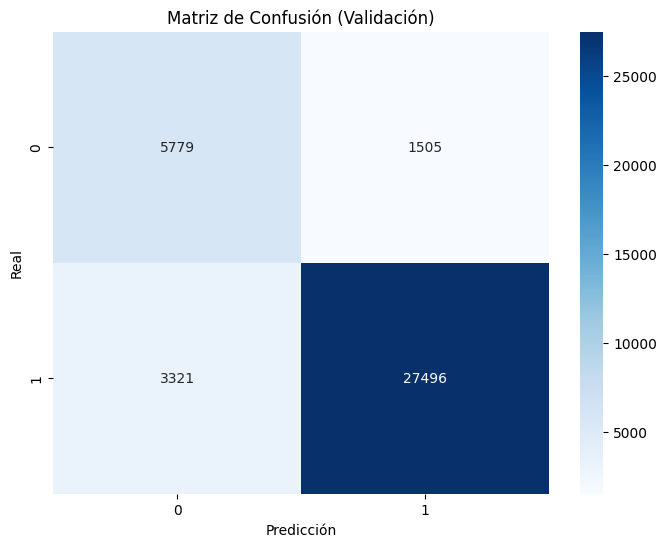

In [41]:
predictions = trainer.predict(val_ds)
y_true = val_df["label"].to_numpy()
y_pred = np.argmax(predictions.predictions, axis=-1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión (Validación)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


Y una matriz de confusión con un **umbral ajustado** para balancear mejor la precisión y el recall, cosa que puede mejorar la clasificación en datasets desbalanceados.

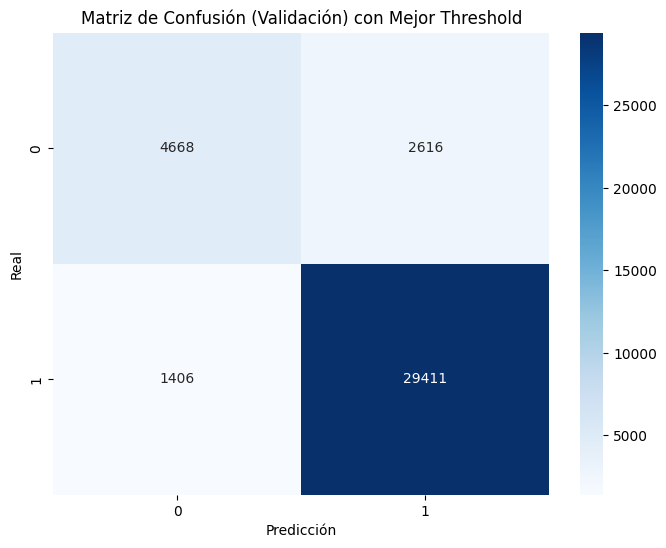

In [42]:
y_pred_thresholded = (torch.softmax(torch.tensor(predictions.predictions), dim=-1)[:,1].numpy() >= best_thr).astype(int)

cm_thresholded = confusion_matrix(y_true, y_pred_thresholded)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_thresholded, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión (Validación) con Mejor Threshold")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

Se hace una **curva ROC** del conjunto de validación.

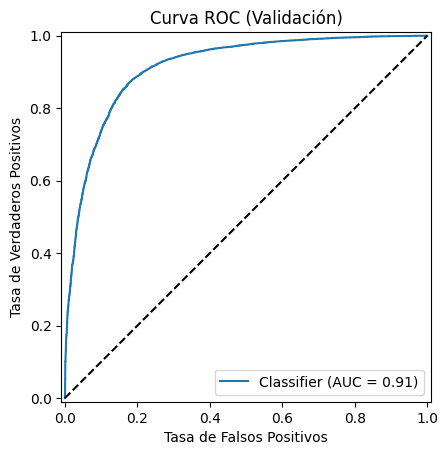

In [43]:
RocCurveDisplay.from_predictions(y_true, torch.softmax(torch.tensor(predictions.predictions), dim=-1)[:,1].numpy())
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.title("Curva ROC (Validación)")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.show()

Y se finaliza con un conteo de las **predicciones** realizadas por el modelo.

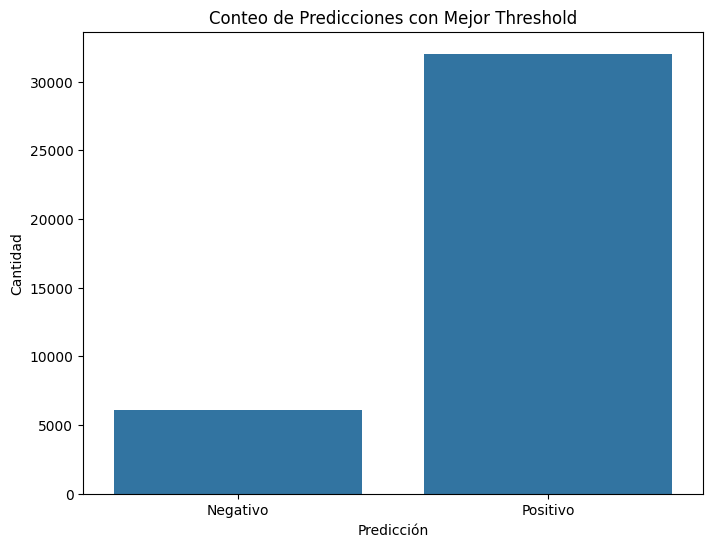

In [44]:
prediction_counts = pd.Series(y_pred_thresholded).value_counts().sort_index()

plt.figure(figsize=(8, 6))
sns.barplot(x=prediction_counts.index, y=prediction_counts.values)
plt.title('Conteo de Predicciones con Mejor Threshold')
plt.xlabel('Predicción')
plt.ylabel('Cantidad')
plt.xticks(ticks=[0, 1], labels=['Negativo', 'Positivo'])
plt.show()